In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
import nltk

## StackOverflow: Tag Prediction

### Real World / Business Objectives and Constraints

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags would impact customer experience on StackOverflow.
No strict latency constraints.

## Exploratory Data Analysis

### 3.1 Data Loading and Cleaning

#### 3.1.1 Using Pandas with SQLite to load the data

In [2]:
# Creating db file from csv
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('D:/3D Objects/Applied AI/Case study/Stackoverflow/Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

### 3.1.2 Counting the number of rows

In [3]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:02.498884


### 3.1.3 Checking for duplicates

In [4]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:01:47.396097


In [5]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [6]:
print("Number of duplicate questions:", num_rows['count(*)'].values[0] - df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100, "%)")

Number of duplicate questions: 1827881 ( 30.292038906260256 %)


In [7]:
# Number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [8]:
df_no_dup.dropna(how='any',axis=0,inplace=True)

In [9]:
# dropping rows with empty values in Tags
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(' ') if text is not None else '0' ))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:01.959057


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [10]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: tag_count, dtype: int64

In [11]:
# creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train', disk_dup)

In [12]:
conn=sqlite3.connect('train_no_dup.db')
no_dup=pd.read_sql_query('Select Title,Body,Tags from no_dup_train',conn)
conn.close() 
no_dup.head()

,Title,Body,Tags
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc


In [13]:
tag_data=pd.DataFrame(no_dup,columns=['Tags'])
tag_data.head()

,Tags
0,c++ c
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc


In [14]:
# This methods seems to work more appropriately with this much data
# creating a connection with database file
# if os.path.isfile('train_no_dup.db'):
#     start = datetime.now()
#     con = sqlite3.connect('train_no_dup.db')
#     tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
#     # Always close the connection
#     con.close()
    
#     #let's now drop unwanted column
#     tag_data.drop(tag_data.index[0], inplace=True)
#     #Printing first 5 columns from our dataframe
#     tag_data.head()
#     print("Time taken to run this cell :", datetime.now() - start)
# else:
#     print("Please download the train.db file from drive or run the above cells to genarate train.db file")

## 3.2 Analysis of Tags

### 3.2.1 Total number of unique tags

In [15]:
# Importing and Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [16]:
print('Number of data points:', tag_dtm.shape[0])
print('Number of unique tags:', tag_dtm.shape[1])
#print(tag_dtm)

Number of data points: 4206308
Number of unique tags: 42048


In [17]:
#get_feature_name() gives us the vocabulary
tags = vectorizer.get_feature_names()
# lets look at tags we have
print('Some of the tags we have', tags[:10])

Some of the tags we have ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### 3.2.3 Number of times a tag appeared

In [18]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [19]:
# Saving this dictionary to csv file
lst=[]
for key, value in result.items():
    lst.append([key,value])   
    
tag_df = pd.DataFrame(lst,columns=['Tags','Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [20]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

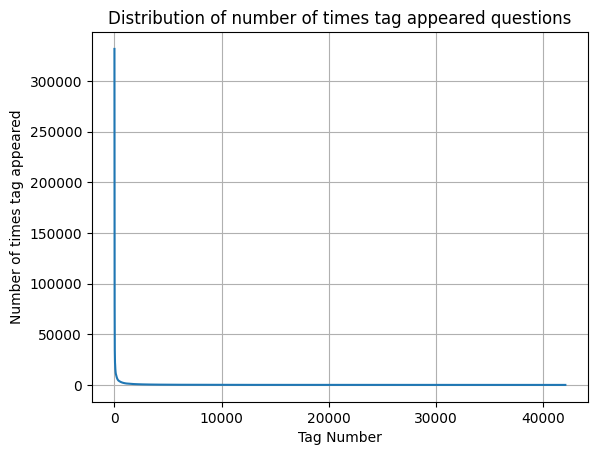

In [21]:
plt.plot(tag_counts)
plt.title('Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel('Tag Number')
plt.ylabel('Number of times tag appeared')
plt.show()

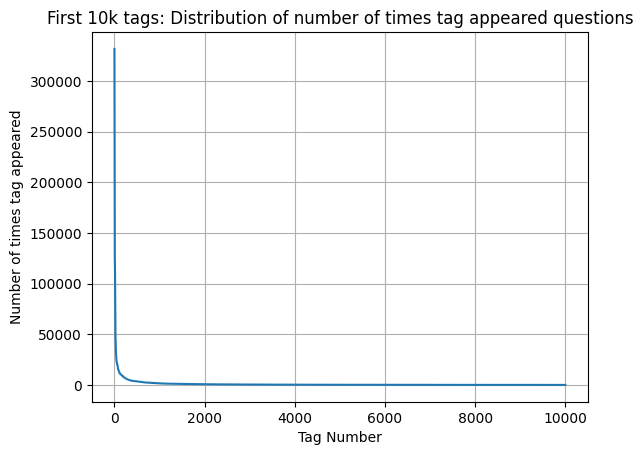

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2986   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

In [22]:
plt.plot(tag_counts[:10000])
plt.title('First 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel('Tag Number')
plt.ylabel('Number of times tag appeared')
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

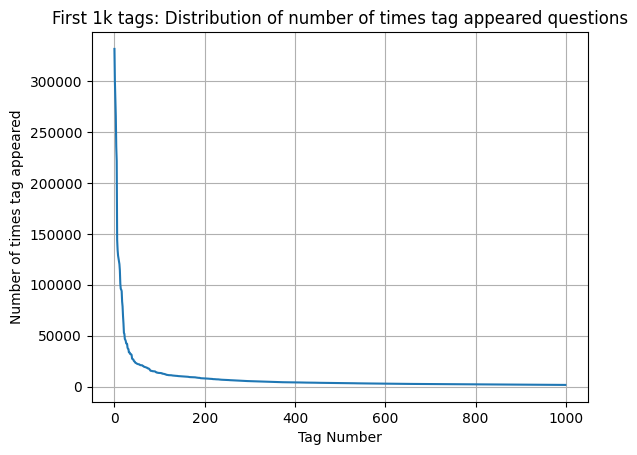

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [23]:
plt.plot(tag_counts[:1000])
plt.title('First 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel('Tag Number')
plt.ylabel('Number of times tag appeared')
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

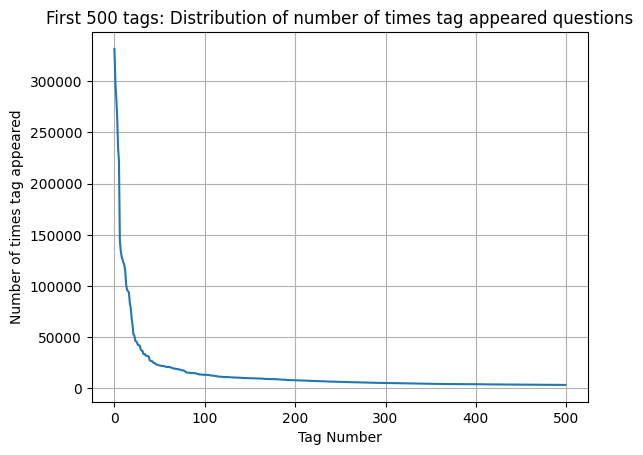

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [24]:
plt.plot(tag_counts[:500])
plt.title('First 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel('Tag Number')
plt.ylabel('Number of times tag appeared')
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

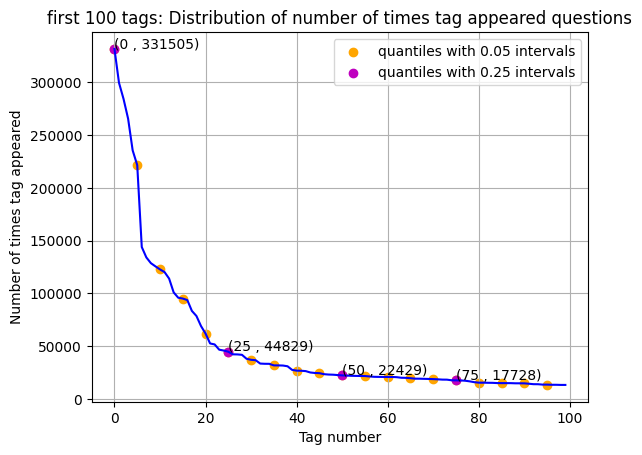

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [25]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate("({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [26]:
# store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#print the length of the list
print('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


#### Observations:

1. There are total 153 tags which are used more than 10000 times.
2. There are total 14 tags which are used more than 100000 times.
3. Most frequent tag (C#) is used 331505 times.
4. Since some tags  occur more frequently than others, Micro-averaged F1-score is the appropriate metric for this problem.

### 3.2.4 Tags per Question

In [27]:
# Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]]
tag_quest_count = [int(j) for i in tag_quest_count for j in i]
print('We have total {} datapoints.'.format(len(tag_quest_count)))
print(tag_quest_count[:5])

We have total 4206308 datapoints.
[2, 3, 4, 2, 2]


In [28]:
print("Maximum number of tags per question: %d"%max(tag_quest_count))
print("Minimum number of tags per question: %d"%min(tag_quest_count))
print("Average number of tags per question: %f"%((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Average number of tags per question: 2.899442


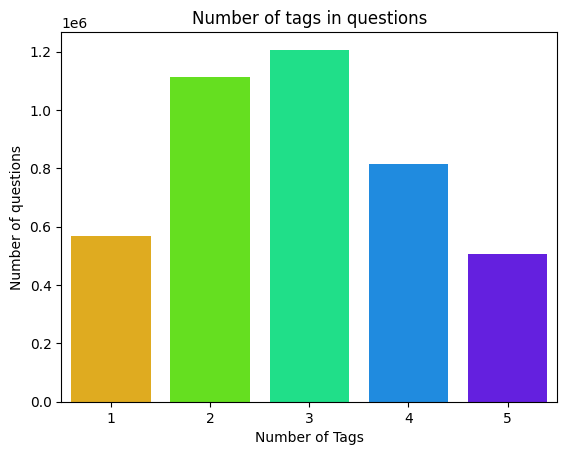

In [29]:
# plotting the number of tags per question 
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title('Number of tags in questions')
plt.xlabel('Number of Tags')
plt.ylabel('Number of questions')
plt.show()

<b>Obervations:</b>
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Average number of tags per question: 2.899
4. Most of the questions have either 2 or 3 tags.

### 3.2.5 Most Frequent Tags

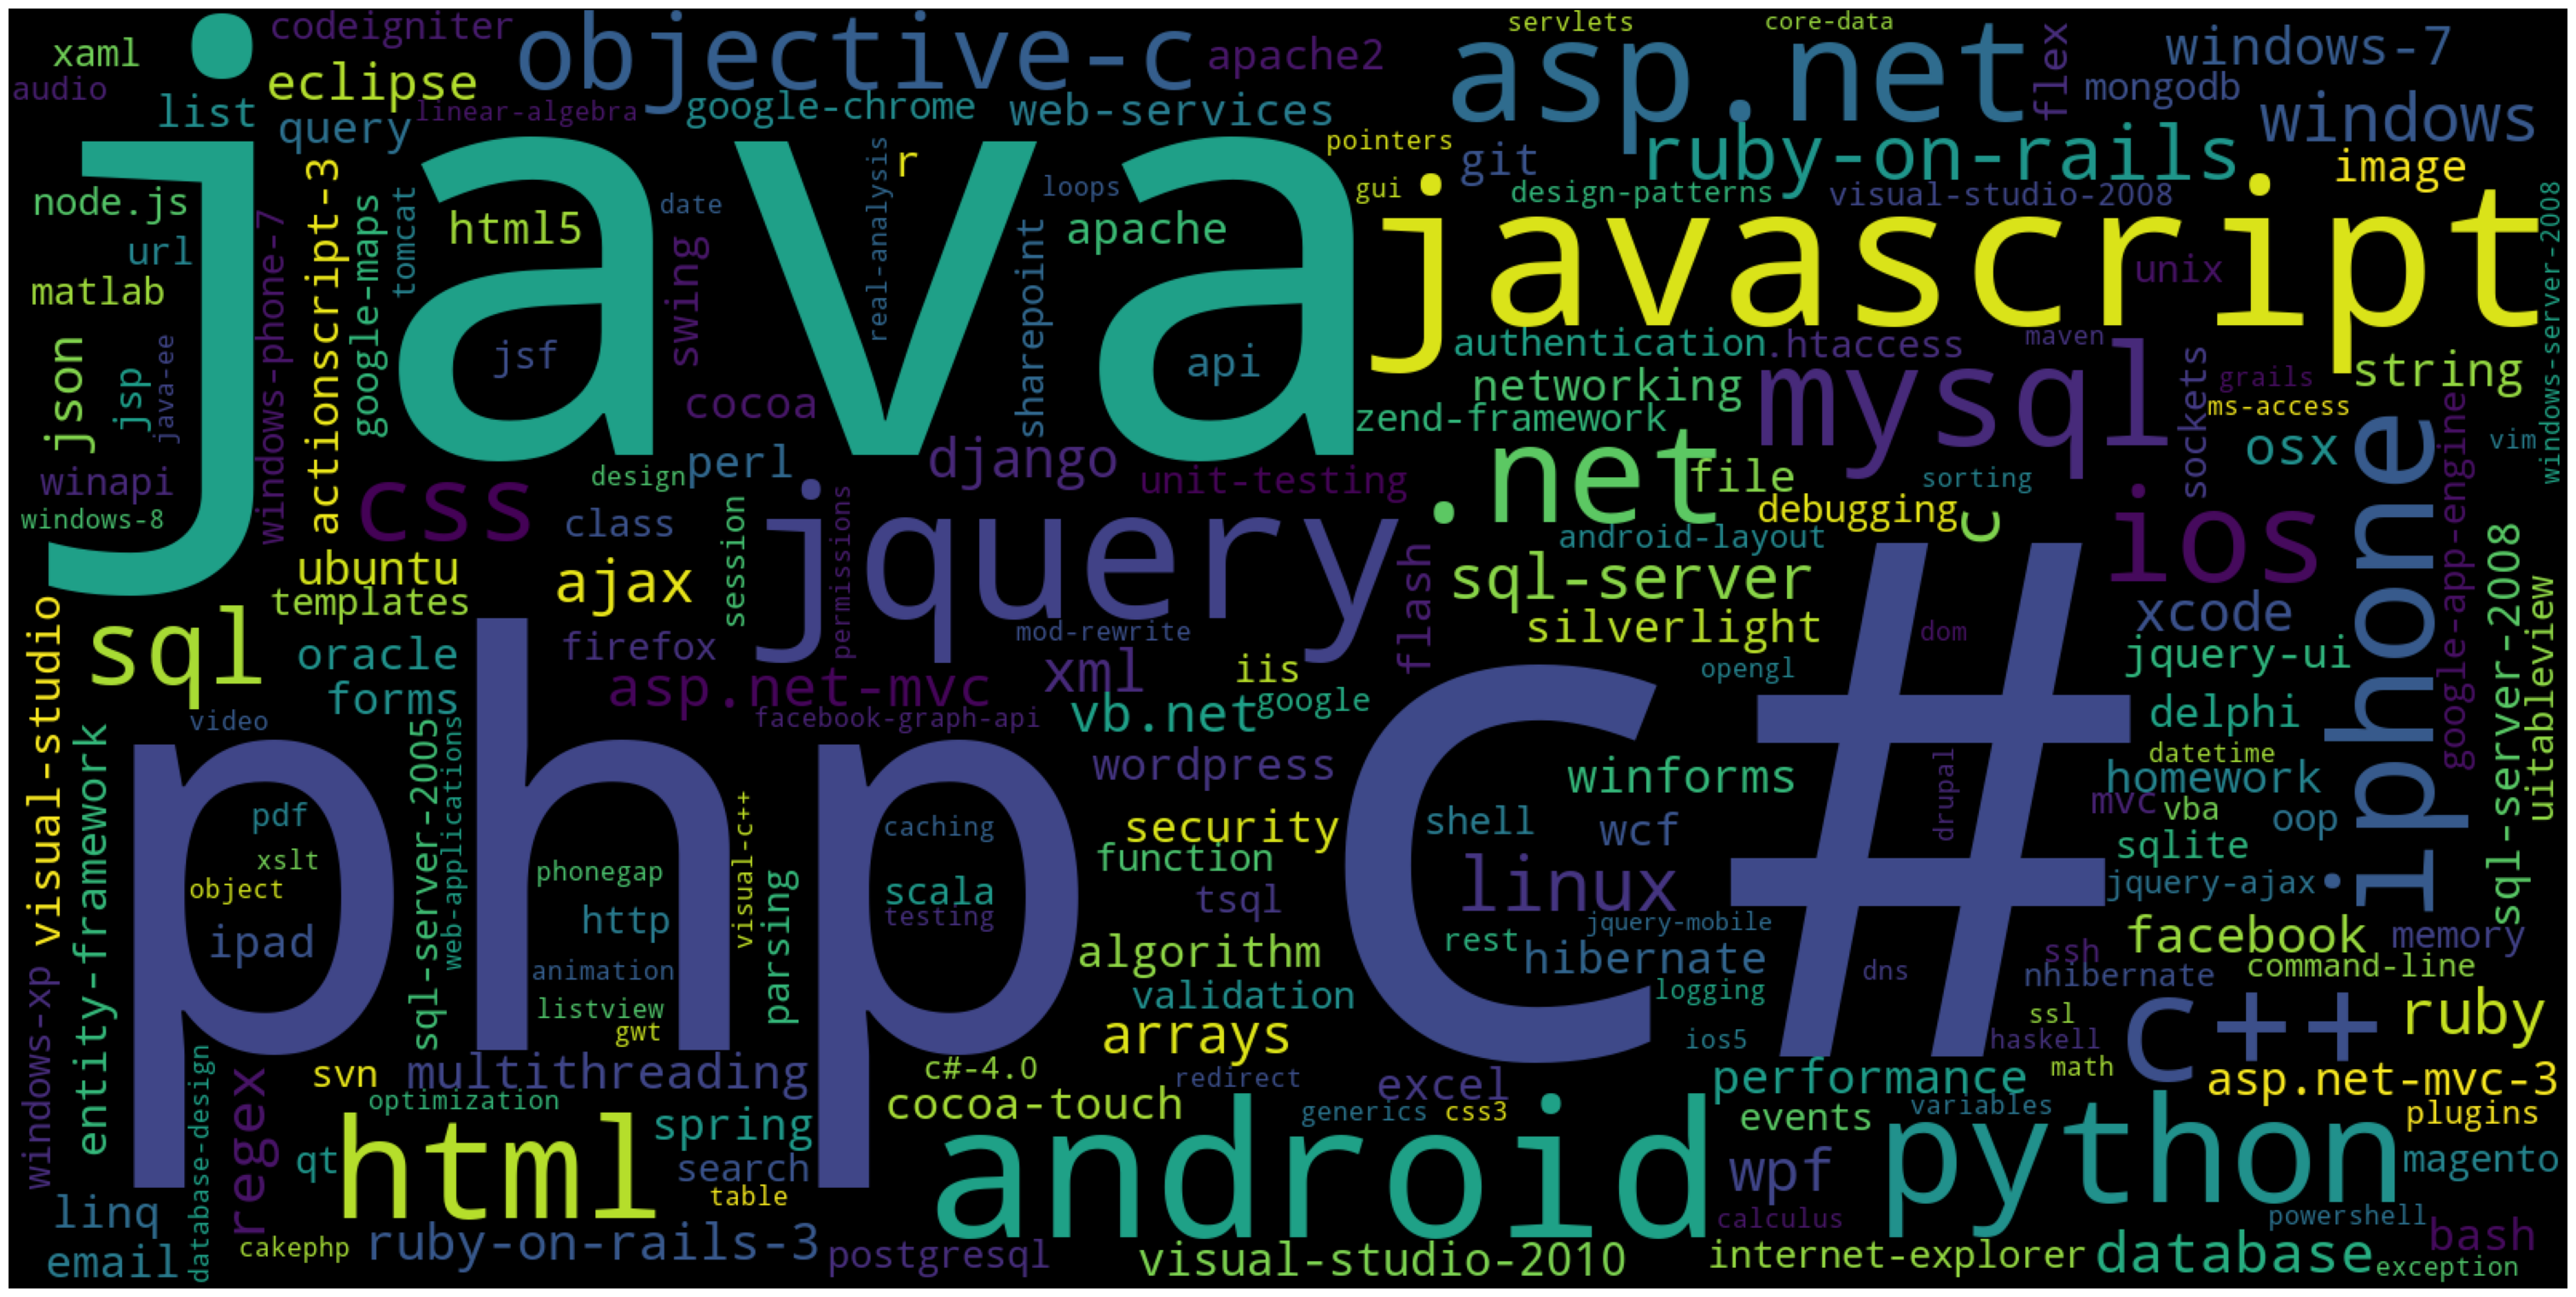

Time taken to run this cell : 0:00:03.916737


In [30]:
# Plotting Wordcloud
start = datetime.now()

# Let's first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
# Initializing Wordcloud using frequencies of tags.
wordcloud = WordCloud(background_color='black',
                      width=1600,
                      height=800,
                     ).generate_from_frequencies(tup)

fig=plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig('tag.png')
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

#### Observations:
From the above image we can see "c#", "Java", "php", "android", "javascript" are the most frequent tags.

### 3.2.6 Top 20 tags

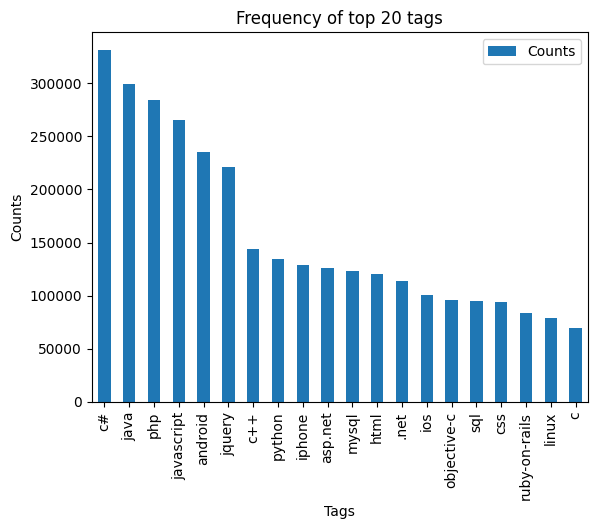

In [31]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'].head(20))
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

#### Observations:
1. Majority of the most frequent tags are programming languages.
2. C# is the most frequent tag.
3. Android, IOS, Linux and windows are among the top most frequent operating systems

### 3.3 Cleaning and preprocessing of Questions

### 3.3.1 Preprocessing

1. Sample 1M data points(easy computation)
2. Separate out code-snippets from Body
3. Remove Spatial characters from Question title and description (not in code)
4. Remove stop words (Except "C")
5. Remove HTML Tags
6. Convert all the characters into small letters
7. Use Snowball Stemmer to stem the words

In [32]:
# nltk.download('stopwords')
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [33]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [34]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:04:42.191270


We create a new database to store the sampled and preprocessed questions

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\verma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%60000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 60000
number of questions completed= 120000
number of questions completed= 180000
number of questions completed= 240000
number of questions completed= 300000
number of questions completed= 360000
number of questions completed= 420000
number of questions completed= 480000
number of questions completed= 540000
number of questions completed= 600000
number of questions completed= 660000
number of questions completed= 720000
number of questions completed= 780000
number of questions completed= 840000
number of questions completed= 900000
number of questions completed= 960000
Avg. length of questions(Title+Body) before processing: 1170
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:15:42.729691


In [37]:
# don't forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [38]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT question from QuestionsProcessed LIMIT 10")
        print('Questions after preprocessed')
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('insert hashmap chang valu store hashmap ok stump one idea caus problem problem occur class given text file find number instanc one letter come anoth hashmapcharact hashmap store key hash charact contain text charact correspond inner hash contain number case charact inner hash key outerhash key inner hash key would contain number time come number time c come number time come forth charact come muteableint hold int valu allow increment method error occur comput total count contain inner hash find total insert key total correct insert pull total later find everi inner hash total take valu last total enter analyz war peac last total enter total count pull total instanc count charact also hope make sens offend code',)
----------------------------------------------------------------------------------------------------
('use string control object current project made mdiform menustrip coupl toolstripmenuitem na coupl button devexpress navbarcontrol intent user l

In [39]:
# Taking 1M entries to a DataFrame
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [40]:
preprocessed_data.head()

,question,tags
0,name function like pseudocod like use tree str...,python function data-structures tree nodes
1,insert hashmap chang valu store hashmap ok stu...,java
2,use string control object current project made...,c# .net winforms
3,date pars javascript differ safari chrome foll...,javascript parsing date google-chrome safari
4,chang locat backup file left fail git mergetoo...,git mergetool


In [32]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 999999
number of dimensions : 2


## 4. Machine Learning Models

### 4.1 Converting tags for multilabel problems

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

Modeling with less data points (0.5M data point) and more weight to title and 500 tags.

In [41]:
# binary=true will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

We will sample the number of tags instead of considering all of them(due to limitation of computinf power)

In [42]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [43]:
questions_explained=[]
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

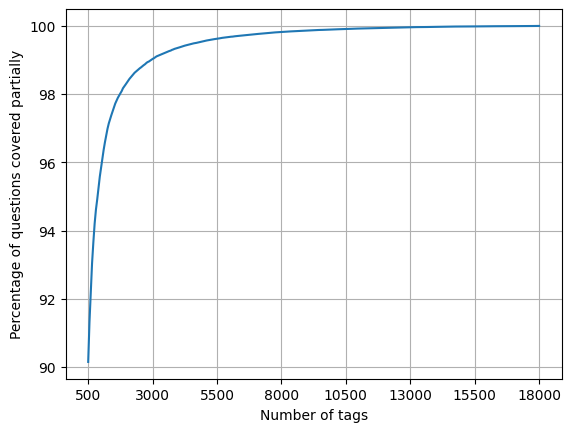

with  5500 tags we are covering  99.032 % of questions


In [44]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel('Number of tags')
plt.ylabel("Percentage of questions covered partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [45]:
multilabel_yx=tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 9683 out of  999999


In [46]:
print('Number of tags in sample:', multilabel_y.shape[1])
print('Number of tags taken:', multilabel_yx.shape[1], "(", (multilabel_yx.shape[1]/multilabel_y.shape[1])*100, "%)")

Number of tags in sample: 35574
Number of tags taken: 5500 ( 15.460729746444033 %)


We consider top 15% of tags which covers 99% of the questions.

## 4.2 Split the data into test and train (80:20)

In [47]:
total_size=preprocessed_data.shape[0]
train_size=int(0.8*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train=multilabel_yx[0:train_size,:]
y_test=multilabel_yx[train_size:total_size,:]

In [48]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799999, 5500)
Number of data points in test data : (200000, 5500)


## 4.3 Featurizing data

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=30000, smooth_idf=True, norm="l2", \
                             tokenizer=lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
print("Dimensions of train data X:", x_train_multilabel.shape, "Y:", y_train.shape)
print("Dimensions of test data X:", x_test_multilabel.shape, "Y:", y_test.shape)

In [ ]:
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
#https://stats.stackexchange.com/questions/117796/scikit-multi-label-classification
# classifier = LabelPowerset(GaussianNB())
"""
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))

"""
# we are getting memory error because the multilearn package 
# is trying to convert the data into dense matrix
# ---------------------------------------------------------------------------
#MemoryError                               Traceback (most recent call last)
#<ipython-input-170-f0e7c7f3e0be> in <module>()
#----> classifier.fit(x_train_multilabel, y_train)

## 4.4 Applying Logistic Regression with OneVsRest Classifier

In [ ]:
# This takes about 6-7 hours to run try not to run it, download the lr_with_equal_weight.pkl file and use to predict


classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


In [ ]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl')

## 4.5 Modeling with less data points(0.5M data points) and more weight to title and 500 tags only

In [42]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [49]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = "train_no_dup.db"
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags from no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer = conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print('Cleared all the rows')

Tables in the databse:
QuestionsProcessed
Cleared all the rows


### 4.5.1 Preprocessing of questions

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [44]:
start = datetime.now()
preprocessed_data_list = []
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed=0
for row in reader:
    is_code=0
    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(title)+" "+str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 412
Percent of questions containing code: 57
Time taken to run this cell : 0:12:38.485003


In [45]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample questions after preprocessing data__

In [46]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advanc',)
----------------------------------------------------------------------------------------------------
('java lang noclassdeffounderror javax servlet jsp tagext taglibraryvalid java lang noclassdeffounderror javax servlet jsp tagext taglibraryvalid java lang noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java lang noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl tomcat webapp tri project work also tri version jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java sql sqlexcept microsoft odbc driver manag inva

__ Saving Preprocessed data to a Database__

In [40]:
#Taking 0.5 Millioon entries to a dataframe
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query('''SELECT question, Tags from QuestionsProcessed''', conn_r)
conn_r.commit()
conn_r.close()

In [41]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java lang noclassdeffounderror javax servlet j...,jsp jstl
3,java sql sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [42]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


Converting tags into multilabel output variables

In [43]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

Selecting 500 tags

In [44]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100, 3))

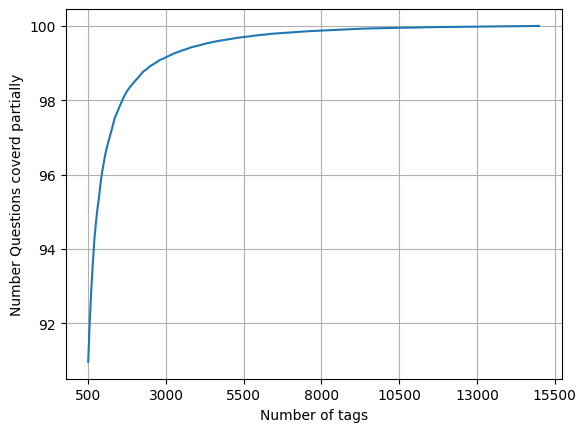

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [45]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [46]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [47]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [48]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


### 4.5.2 Featurizing data with Tfidf Vectorizer

In [49]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm='l2', \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel= vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:22.901639


In [50]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 98846) Y : (400000, 500)
Dimensions of test data X: (100000, 98846) Y: (100000, 500)


### 4.5.3 Applying Logistic Regression with OneVsRest Classifier

In [51]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23152
Hamming loss  0.00282472
Micro-average quality numbers
Precision: 0.7066, Recall: 0.3206, F1-measure: 0.4410
Macro-average quality numbers
Precision: 0.5217, Recall: 0.2541, F1-measure: 0.3261
              precision    recall  f1-score   support

           0       0.95      0.65      0.77      5519
           1       0.65      0.25      0.36      8190
           2       0.80      0.37      0.51      6529
           3       0.70      0.35      0.46      3231
           4       0.80      0.41      0.54      6430
           5       0.82      0.35      0.49      2879
           6       0.85      0.50      0.63      5086
           7       0.87      0.55      0.68      4533
           8       0.54      0.13      0.21      3000
           9       0.81      0.53      0.64      2765
          10       0.57      0.16      0.25      3051
          11       0.70      0.33      0.45      3009
          12       0.62      0.23      0.33      2630
          13       0.65      0.

#### Observation:
The model gives a precision of 0.7057, recall of 0.3201 and f1-measure of 0.4404 for micro-averaged F1-score. Though the precision is high but the recall value is less and hence a lower F1-score.

In [52]:
import joblib
joblib.dump(classifier, 'lr_with_more_title_weight.pkl')

['lr_with_more_title_weight.pkl']

In [53]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l2'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23468
Hamming loss  0.00278914
Micro-average quality numbers
Precision: 0.7300, Recall: 0.3136, F1-measure: 0.4388
Macro-average quality numbers
Precision: 0.5569, Recall: 0.2286, F1-measure: 0.3074
              precision    recall  f1-score   support

           0       0.95      0.69      0.80      5519
           1       0.67      0.31      0.42      8190
           2       0.80      0.38      0.52      6529
           3       0.74      0.37      0.49      3231
           4       0.80      0.42      0.55      6430
           5       0.82      0.37      0.51      2879
           6       0.86      0.51      0.64      5086
           7       0.87      0.57      0.69      4533
           8       0.55      0.12      0.20      3000
           9       0.83      0.56      0.67      2765
          10       0.59      0.18      0.27      3051
          11       0.71      0.34      0.46      3009
          12       0.62      0.25      0.35      2630
          13       0.69      0.

## 5.1 Using Bag of Words upto 4 grams

In [51]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

number of questions that are not covered : 98536 out of  999999
Number of data points in train data : (400000, 500)
Number of data points in test data : (599999, 500)


In [52]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=100000, analyzer='word', tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel= vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:06:04.141498


In [53]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 90222) Y : (400000, 500)
Dimensions of test data X: (599999, 90222) Y: (599999, 500)


In [60]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.12515187525312543
Hamming loss  0.00441820736367894
Micro-average quality numbers
Precision: 0.4000, Recall: 0.4472, F1-measure: 0.4223
Macro-average quality numbers
Precision: 0.2958, Recall: 0.3773, F1-measure: 0.3294
              precision    recall  f1-score   support

           0       0.44      0.42      0.43     47557
           1       0.56      0.54      0.55     42709
           2       0.64      0.62      0.63     40596
           3       0.54      0.50      0.52     37872
           4       0.84      0.83      0.84     33658
           5       0.71      0.66      0.68     31574
           6       0.49      0.46      0.47     20635
           7       0.72      0.69      0.70     19120
           8       0.52      0.50      0.51     18338
           9       0.53      0.51      0.52     17947
          10       0.67      0.64      0.66     17320
          11       0.31      0.28      0.30     17137
          12       0.24      0.21      0.22     16416
          

In [62]:
import joblib
joblib.dump(classifier, 'lr_with_more_title_weight_4gram.pkl')

['lr_with_more_title_weight_4gram.pkl']

## 5.2 Hyperparameter tuning using GridSearch

In [60]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()
param_grid = {
    'estimator__loss': ['log'],
    'estimator__alpha': [0.0001, 0.001, 0.01, 1],
    'estimator__penalty': ['l1']}

classifier = OneVsRestClassifier(SGDClassifier(random_state=21))
grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, scoring='f1_micro', verbose=3)
grid.fit(x_train_multilabel, y_train)
predictions = grid.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END estimator__alpha=0.0001, estimator__loss=log, estimator__penalty=l1;, score=0.458 total time=34.7min
[CV 2/3] END estimator__alpha=0.0001, estimator__loss=log, estimator__penalty=l1;, score=0.455 total time=30.0min
[CV 3/3] END estimator__alpha=0.0001, estimator__loss=log, estimator__penalty=l1;, score=0.455 total time=31.5min
[CV 1/3] END estimator__alpha=0.001, estimator__loss=log, estimator__penalty=l1;, score=0.376 total time=15.1min
[CV 2/3] END estimator__alpha=0.001, estimator__loss=log, estimator__penalty=l1;, score=0.377 total time=16.1min
[CV 3/3] END estimator__alpha=0.001, estimator__loss=log, estimator__penalty=l1;, score=0.376 total time=16.4min
[CV 1/3] END estimator__alpha=0.01, estimator__loss=log, estimator__penalty=l1;, score=0.160 total time=14.8min
[CV 2/3] END estimator__alpha=0.01, estimator__loss=log, estimator__penalty=l1;, score=0.163 total time=13.9min
[CV 3/3] END estimator__alpha=0.01,

The best score is obtained at alpha = 0.0001 that is 0.458.

## 5.3 OneVsRest with Linear-SVM

In [54]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()
param_grid = {
    'estimator__loss': ['hinge'],
    'estimator__alpha': [0.0001, 0.001, 0.01, 1],
    'estimator__penalty': ['l1']}

classifier = OneVsRestClassifier(SGDClassifier(random_state=21))
grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, scoring='f1_micro', verbose=3)
grid.fit(x_train_multilabel, y_train)

best_alpha = grid.best_estimator_.get_params()['estimator__alpha']
print('Best alpha ', best_alpha)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l1;, score=0.450 total time=26.5min
[CV 2/3] END estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l1;, score=0.452 total time=28.4min
[CV 3/3] END estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l1;, score=0.451 total time=27.1min
[CV 1/3] END estimator__alpha=0.001, estimator__loss=hinge, estimator__penalty=l1;, score=0.389 total time=11.0min
[CV 2/3] END estimator__alpha=0.001, estimator__loss=hinge, estimator__penalty=l1;, score=0.374 total time=12.0min
[CV 3/3] END estimator__alpha=0.001, estimator__loss=hinge, estimator__penalty=l1;, score=0.385 total time=13.1min
[CV 1/3] END estimator__alpha=0.01, estimator__loss=hinge, estimator__penalty=l1;, score=0.199 total time= 8.2min
[CV 2/3] END estimator__alpha=0.01, estimator__loss=hinge, estimator__penalty=l1;, score=0.162 total time= 9.0min
[CV 3/3] END estima

In [56]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l1', random_state=21), n_jobs=-1)

classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.18382697304495507
Hamming loss  0.0033420955701592837
Micro-average quality numbers
Precision: 0.5538, Recall: 0.3812, F1-measure: 0.4516
Macro-average quality numbers
Precision: 0.3756, Recall: 0.3192, F1-measure: 0.3295
              precision    recall  f1-score   support

           0       0.61      0.16      0.26     47225
           1       0.69      0.49      0.57     42820
           2       0.77      0.57      0.66     40062
           3       0.71      0.46      0.56     38059
           4       0.87      0.81      0.84     33755
           5       0.79      0.66      0.72     31548
           6       0.54      0.38      0.45     20369
           7       0.78      0.66      0.72     18948
           8       0.58      0.44      0.50     18350
           9       0.68      0.47      0.56     17813
          10       0.76      0.64      0.69     17374
          11       0.47      0.05      0.10     17218
          12       0.43      0.06      0.11     16136
        

## Conclusion

In [1]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Classifier", "Vectorizer", "Hyperparameter", "Regularization", "Micro F1 score"]
table.add_row(["Logistic Regression", "Tfidf", 0.00001, 'L1', 0.4410])
table.add_row(["Logistic Regression", "Tfidf", 1.0, 'L2', 0.4388])
table.add_row(["Logistic Regression", "Count vectorizer (4-gram)", 0.00001, 'L1', 0.4223])
table.add_row(["Logistic Regression", "Count vectorizer (4-gram)", 0.0001, 'L1', 0.4585])
table.add_row(["Linear SVM", "Count vectorizer (4-gram)", 0.0001, 'L1', 0.4516])

print(table)

+---------------------+---------------------------+----------------+----------------+----------------+
|      Classifier     |         Vectorizer        | Hyperparameter | Regularization | Micro F1 score |
+---------------------+---------------------------+----------------+----------------+----------------+
| Logistic Regression |           Tfidf           |     1e-05      |       L1       |     0.441      |
| Logistic Regression |           Tfidf           |      1.0       |       L2       |     0.4388     |
| Logistic Regression | Count vectorizer (4-gram) |     1e-05      |       L1       |     0.4223     |
| Logistic Regression | Count vectorizer (4-gram) |     0.0001     |       L1       |     0.4585     |
|      Linear SVM     | Count vectorizer (4-gram) |     0.0001     |       L1       |     0.4516     |
+---------------------+---------------------------+----------------+----------------+----------------+


* High Dimensionality - Here we limited ourselves to simple linear models likes Logistic Regression and Linear SVM. Because we used Count vectorizers and Tf-idf vectorizers and our data is high dimensional, Decision Tree, Random Forest, GBDT would fail to work.
* Time Complexity – As we have considered 500 labels, so we have to train 500 model and hence Linear model makes more sense.
